### Import Statements

In [1]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectFromModel, SelectPercentile, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlxtend.feature_selection import ColumnSelector, SequentialFeatureSelector
import pandas as pd
import numpy as np
#from xgboost import XGBRegressor
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor
import seaborn as sns
from sklearn.tree import export_graphviz

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(30647, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(30647, 24)

### Finding Test hours

In [19]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.15)

In [21]:
test_hours = data.loc[y_test.index, 'HourOfDay']

### Quantile Cuts for Hour of Day to divide Hour of Days into 4 Main 6 Hour Categories

In [22]:
data['HourOfDay'] = pd.qcut(data['HourOfDay'], 4)

In [23]:
data.dtypes

pickup_time                      object
num_passengers                  float64
temp                            float64
temp_min                        float64
temp_max                        float64
humidity                        float64
wind_speed                      float64
Passengers                      float64
Month                             int64
HourOfDay                      category
DayOfWeek                         int64
holiday                           int64
precip_in                       float64
Avg_Delay_Arriving              float64
Avg_Delay_Departing             float64
Cancelled_Arriving_Flights      float64
Cancelled_Departing_Flights     float64
clear                             int64
clouds                            int64
fog                               int64
rain                              int64
snow                              int64
thunderstorm                      int64
dtype: object

In [24]:
data.head()

,pickup_time,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,"(-0.001, 6.0]",2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Drop the Pickup Time and Number of Passengers

In [25]:
data.drop([
        "pickup_time",
        "num_passengers"], axis=1, inplace=True)

### Dropping cancelled arriving flights as they should have no influence in pickups at LGA

In [26]:
## as they will probably have no predictive value
data.drop(['Cancelled_Arriving_Flights'], axis=1, inplace=True)

In [27]:
data.drop(['Avg_Delay_Departing'], axis=1, inplace=True)

### Last 2 hour Passengers (1 Hour Ago and 2 Hours Ago)

In [28]:
data['Prev_hour_Passengers'] = data['Passengers'].shift(1)
data['Prev_2hour_Passengers'] = data['Passengers'].shift(2)

In [29]:
data.Prev_hour_Passengers = data.Prev_hour_Passengers.fillna(method='bfill')
data.Prev_2hour_Passengers = data.Prev_2hour_Passengers.fillna(method='bfill')

### Dropping Temp_Mix and Temp_Max as we already have Temp

In [30]:
data.drop(['temp_min', 'temp_max'], axis=1, inplace=True)

### Converting Month and Day of Week to Categorical Data

In [31]:
data.Month = pd.Categorical(data.Month)
data.DayOfWeek = pd.Categorical(data.DayOfWeek)

In [32]:
data = pd.get_dummies(data)

In [33]:
data.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [34]:
data.dtypes

temp                           float64
humidity                       float64
wind_speed                     float64
Passengers                     float64
holiday                          int64
precip_in                      float64
Avg_Delay_Arriving             float64
Cancelled_Departing_Flights    float64
clear                            int64
clouds                           int64
fog                              int64
rain                             int64
snow                             int64
thunderstorm                     int64
Prev_hour_Passengers           float64
Prev_2hour_Passengers          float64
Month_1                          uint8
Month_2                          uint8
Month_3                          uint8
Month_4                          uint8
Month_5                          uint8
Month_6                          uint8
Month_7                          uint8
Month_8                          uint8
Month_9                          uint8
Month_10                 

## MODELS FOLLOW FROM HERE

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.15)

In [36]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

### VIsualizing mutual_info

In [37]:
X_train.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
4536,296.75,78.0,6.0,0.0,0,0.0,188.125000,0.0,0,1,0,0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
21071,295.65,61.0,2.0,0.0,0,0.0,110.500000,0.0,0,0,0,1,0,0,0.0,87.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
16132,282.45,76.0,1.0,0.0,0,0.0,0.000000,0.0,0,0,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
24852,285.56,50.0,1.0,532.0,0,0.0,2.235294,0.0,0,1,0,0,0,0,299.0,765.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
16125,286.44,48.0,1.0,447.0,0,0.0,16.684211,0.0,0,0,1,0,0,0,693.0,1188.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0


In [38]:
categorical_cols = X_train.select_dtypes(include=['int64', 'uint8'])
continuous_cols = X_train.select_dtypes(exclude=['int64', 'uint8'])

In [39]:
continuous_cols

,temp,humidity,wind_speed,Passengers,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,Prev_hour_Passengers,Prev_2hour_Passengers
4536,296.750000,78.000000,6.000000,0.0,0.00,188.125000,0.0,0.0,0.0
21071,295.650000,61.000000,2.000000,0.0,0.00,110.500000,0.0,0.0,87.0
16132,282.450000,76.000000,1.000000,0.0,0.00,0.000000,0.0,0.0,0.0
24852,285.560000,50.000000,1.000000,532.0,0.00,2.235294,0.0,299.0,765.0
16125,286.440000,48.000000,1.000000,447.0,0.00,16.684211,0.0,693.0,1188.0
7288,284.630000,54.000000,4.000000,1516.0,0.00,13.285714,0.0,1023.0,614.0
20463,286.670000,71.000000,1.000000,1802.0,0.00,36.789474,0.0,1097.0,737.0
9077,263.074000,70.000000,2.000000,924.0,0.00,0.000000,0.0,0.0,0.0
20565,282.820000,93.000000,5.000000,442.0,0.00,91.833333,0.0,931.0,1171.0
30088,292.450000,42.000000,3.000000,1796.0,0.00,28.750000,1.0,1345.0,1008.0


In [40]:
def plot_mutual_info(data, columns):
    inds = np.argsort(data)
    plt.figure(figsize = (10,15))
    plt.barh(np.arange(len(data)), np.log(np.array(data)[inds] + 1))
    plt.yticks(np.arange(len(data)), np.array(columns)[inds])
    plt.ylim(0, len(data))
    plt.xlabel('Mutual Information')

In [41]:
mi_continuous = mutual_info_regression(continuous_cols, y_train, discrete_features=False, n_neighbors = 3, 
                                    random_state=42)


mi_categorical = mutual_info_regression(categorical_cols, y_train, discrete_features=True, n_neighbors = 3, 
                                     random_state=42)

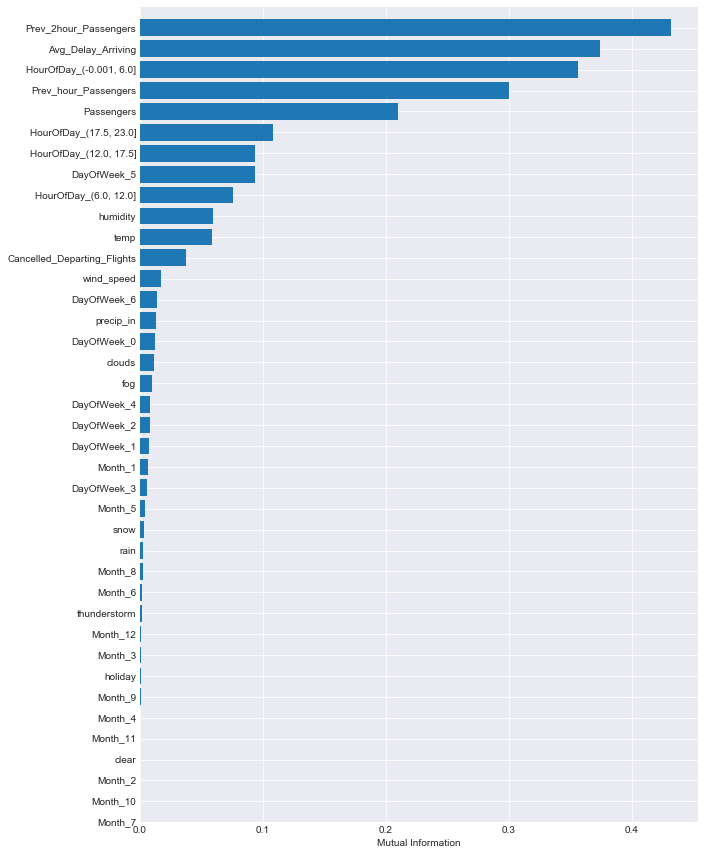

In [42]:
mutual_info = mi_continuous.tolist() + mi_categorical.tolist()
mutual_info_columns = continuous_cols.columns.tolist() + categorical_cols.columns.tolist()
plot_mutual_info(mutual_info, mutual_info_columns)

In [43]:
data.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,"HourOfDay_(-0.001, 6.0]","HourOfDay_(6.0, 12.0]","HourOfDay_(12.0, 17.5]","HourOfDay_(17.5, 23.0]",DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,108.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,108.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


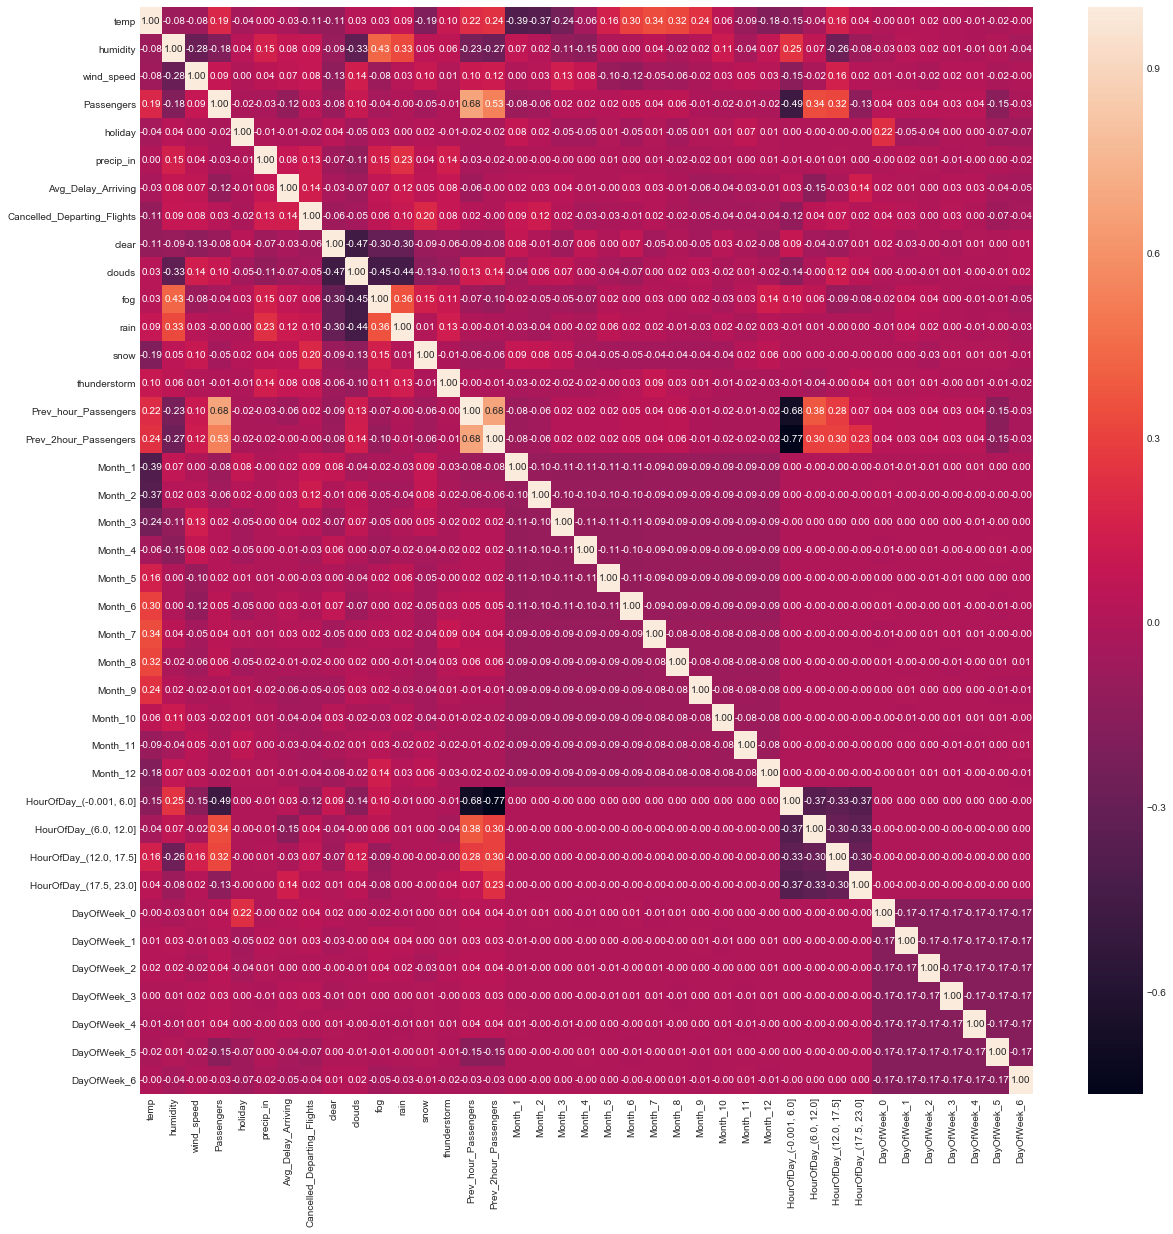

In [44]:
cor_scaler = StandardScaler()
data_scaled = cor_scaler.fit_transform(data)
plt.figure(figsize=(20,20))
sns.heatmap(pd.DataFrame(data_scaled, columns=data.columns).corr(),
           annot=True, fmt=".2f")

### Some functions

In [44]:
def get_predictions(X_train, y_train, X_test, classifier):
    classifier.fit(X_train, y_train)
    classifier.score(X_test, y_test)
    return classifier.predict(X_test)

In [45]:
def plot_errors_hour(data, predictions, y_test):
    test_hours = data['HourOfDay'].loc[y_test.index]
    errors_df = pd.DataFrame({'HourOfDay' : test_hours, 'y_test' : y_test, 'predictions' : predictions})
    errors_df['error'] = errors_df.predictions - errors_df.y_test
    errors_df['error frac'] = errors_df.error / errors_df.y_test
    errors_df_hourly = errors_df.groupby('HourOfDay').agg({'error' : 'mean', 'error frac' : 'mean'})
    errors_df_hourly.plot(kind = 'bar')
    return errors_df_hourly

## Model_Ridge : Ridge Regression

In [47]:
select_lassocv = SelectFromModel(LassoCV(), threshold="median")
ridge_pipe = make_pipeline(StandardScaler(), select_lassocv, PolynomialFeatures(interaction_only=True),
                           VarianceThreshold(), Ridge())
ridge_params = {'ridge__alpha' : [0.01, 0.1, 1.0, 10.0, 100.0, np.log(14)],
                'polynomialfeatures__degree' : [2, 3]}

In [48]:
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [55]:
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.01 .................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=0.1 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialfeatures__degree=2, ridge__alpha=1.0 ..................
[CV] polynomialf

[Parallel(n_jobs=-1)]: Done  34 out of  60 | elapsed:  1.3min remaining:   59.5s


[CV]  polynomialfeatures__degree=3, ridge__alpha=1.0, score=0.6920658633480757, total=  32.2s
[CV] polynomialfeatures__degree=3, ridge__alpha=2.63905732962 ........
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7731814807332836, total=  31.9s
[CV] polynomialfeatures__degree=3, ridge__alpha=2.63905732962 ........
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7966605996588849, total=  46.7s
[CV]  polynomialfeatures__degree=3, ridge__alpha=1.0, score=0.7963440263202232, total=  55.5s
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7215931608662844, total=  35.2s
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7871485540977703, total=  36.8s
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.7611727525416994, total=  29.9s
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.782442778992642, total=  32.1s
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.7944703789995013, total=  30.5s
[CV

[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:  2.5min remaining:   13.9s


[CV]  polynomialfeatures__degree=3, ridge__alpha=0.01, score=0.7681574519133159, total= 2.2min
[CV]  polynomialfeatures__degree=3, ridge__alpha=10.0, score=0.7701411444128177, total= 1.9min
[CV]  polynomialfeatures__degree=3, ridge__alpha=1.0, score=0.7683475267421747, total= 2.0min
[CV]  polynomialfeatures__degree=3, ridge__alpha=100.0, score=0.783926841133593, total= 1.6min
[CV]  polynomialfeatures__degree=3, ridge__alpha=2.63905732962, score=0.768668400566609, total= 1.4min


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='aut...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 2.6390573296152584], 'polynomialfeatures__degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [58]:
ridge_grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10.0}

In [59]:
ridge_grid.best_score_

0.7966569404213073

In [61]:
joblib.dump(ridge_grid.best_estimator_, "gridSearch_Models/model_ridge.pkl")

['gridSearch_Models/model_ridge.pkl']

### Random Forest

In [83]:
rf_pipe = make_pipeline(RandomForestRegressor(n_jobs=-1))
rf_params = {'randomforestregressor__n_estimators' : [50, 100, 200], 
             'randomforestregressor__max_features' : ["auto", "sqrt", "log2"],
             'randomforestregressor__max_depth' : [5, 9, 11, 15, 17, 21],
#              'randomforestregressor__criterion' : ['mae', 'mse'],
             'randomforestregressor__warm_start' : [True]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='r2', verbose=5, n_jobs=-1)

In [84]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100,

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.7649308771789372, total=   4.2s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.7822090798993051, total=   7.1s
[CV] randomforestregressor__max_depth=9, randomforestregressor__max_features=auto, randomforestregre

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   36.8s


[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.8355768419808625, total=   7.9s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=50, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__warm_start=True, score=0.835830494574447, total=   7.9s
[CV] randomforestregressor__max_depth=15, randomforestregressor__max_features=auto, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True 
[CV]  randomforestregressor__max_depth=11, randomforestregressor__max_features=log2, randomforestregressor__n_estimators=100, randomforestregressor__warm_start=True, score=0.8316927917937819, total=   4.1s
[CV] randomforestregressor__max_depth=15, randomforest

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [50, 100, 200], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__max_depth': [5, 9, 11, 15, 17, 21], 'randomforestregressor__warm_start': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=5)

In [85]:
rf_grid.best_score_

0.85750342090728926

In [86]:
rf_grid.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__warm_start': True}

In [87]:
joblib.dump(rf_grid.best_estimator_, "gridSearch_Models/model_rf.pkl")

['gridSearch_Models/model_rf.pkl']

### Gradient Boosting Regressor

In [99]:
gbt_pipe = make_pipeline(GradientBoostingRegressor(random_state=0))
gbt_params = {'gradientboostingregressor__n_estimators' : [50, 100, 200],
              'gradientboostingregressor__max_features' : ["auto", "sqrt"],
#              'gradientboostingregressor__subsample' : [0.2, 0.5, 1.0],
              'gradientboostingregressor__max_depth' : [5, 10, 15],
              'gradientboostingregressor__warm_start' : [False]
             }

gbt_grid = GridSearchCV(gbt_pipe, gbt_params, cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [100]:
gbt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_depth=5, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=100, gradientboostingregressor__warm_start=False 
[CV] gradientboostingregressor__max_de

[Parallel(n_jobs=-1)]: Done  74 out of  90 | elapsed:  4.4min remaining:   57.6s


[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, score=0.8409522393044644, total= 3.7min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=auto, gradientboostingregressor__n_estimators=50, gradientboostingregressor__warm_start=False, score=0.8463605727584549, total= 3.7min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.8609121494602631, total= 1.6min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingregressor__n_estimators=200, gradientboostingregressor__warm_start=False, score=0.8632925860091061, total= 2.2min
[CV]  gradientboostingregressor__max_depth=15, gradientboostingregressor__max_features=sqrt, gradientboostingr

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min...ors=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gradientboostingregressor__n_estimators': [50, 100, 200], 'gradientboostingregressor__max_features': ['auto', 'sqrt'], 'gradientboostingregressor__max_depth': [5, 10, 15], 'gradientboostingregressor__warm_start': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [101]:
gbt_grid.best_params_

{'gradientboostingregressor__max_depth': 10,
 'gradientboostingregressor__max_features': 'sqrt',
 'gradientboostingregressor__n_estimators': 200,
 'gradientboostingregressor__warm_start': False}

In [102]:
gbt_grid.best_score_

0.8656520267323643

In [103]:
joblib.dump(gbt_grid.best_estimator_, "gridSearch_Models/model_gbt_warmNo.pkl")

['gridSearch_Models/model_gbt_warmNo.pkl']

## Decision Tree Regressor

## XGBoost Regressor

In [112]:
X_train.rename(columns={'HourOfDay_(-0.001, 6.0]':'first6', 'HourOfDay_(6.0, 12.0]':'6to12', 
                       'HourOfDay_(12.0, 17.5]': '12to18', 'HourOfDay_(17.5, 23.0]': '18to24'}, inplace=True)

/home/ecbm4040/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [113]:
X_train.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,Prev_hour_Passengers,Prev_2hour_Passengers,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,first6,6to12,12to18,18to24,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
4536,296.75,78.0,6.0,0.0,0,0.0,188.125000,0.000000,0.0,0,1,0,0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
21071,295.65,61.0,2.0,0.0,0,0.0,110.500000,71.000000,0.0,0,0,0,1,0,0,0.0,87.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
16132,282.45,76.0,1.0,0.0,0,0.0,0.000000,0.000000,0.0,0,0,1,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
24852,285.56,50.0,1.0,532.0,0,0.0,2.235294,3.733333,0.0,0,1,0,0,0,0,299.0,765.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
16125,286.44,48.0,1.0,447.0,0,0.0,16.684211,9.375000,0.0,0,0,1,0,0,0,693.0,1188.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0


In [46]:
n_estimators = [50, 100, 200]
max_depth = [5, 7]
learning_rate = [0.1]
subsample = [1.0]
colsample_bytree = [0.7]
colsample_bylevel = [0.6]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
param_grid = dict(xgbregressor__n_estimators=n_estimators, 
                  xgbregressor__max_depth=max_depth, 
                  xgbregressor__learning_rate=learning_rate, 
                  xgbregressor__subsample=subsample, 
                  xgbregressor__colsample_bytree=colsample_bytree, 
                  xgbregressor__colsample_bylevel=colsample_bylevel,
                  xgbregressor__gamma=gamma
                 )
xgb_pipe = make_pipeline(XGBRegressor())
xgb_grid = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=5, scoring='r2', verbose=3, n_jobs=-1)

In [122]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.1, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV] xgbregressor__colsample_bylevel=0.6, xgbr

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  2.8min


[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.2, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8603998481851565, total= 1.5min
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.4, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.3, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0, score=0.8513402759537356, total= 1.0min
[CV] xgbregressor__cols

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  8.2min


[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=5, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0, score=0.850993974896148, total=  34.4s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=100, xgbregressor__subsample=1.0 
[CV]  xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=50, xgbregressor__subsample=1.0, score=0.8550747425119667, total=  25.0s
[CV] xgbregressor__colsample_bylevel=0.6, xgbregressor__colsample_bytree=0.7, xgbregressor__gamma=0.9, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=7, xgbregressor__n_estimators=200, xgbregressor__subsample=1.0 
[CV]  xgbregressor__cols

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgbregressor', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xgbregressor__n_estimators': [50, 100, 200], 'xgbregressor__max_depth': [5, 7], 'xgbregressor__learning_rate': [0.1], 'xgbregressor__subsample': [1.0], 'xgbregressor__colsample_bytree': [0.7], 'xgbregressor__colsample_bylevel': [0.6], 'xgbregressor__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [123]:
xgb_grid.best_score_

0.86382908730863817

In [124]:
xgb_grid.best_params_

{'xgbregressor__colsample_bylevel': 0.6,
 'xgbregressor__colsample_bytree': 0.7,
 'xgbregressor__gamma': 1.1,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 7,
 'xgbregressor__n_estimators': 200,
 'xgbregressor__subsample': 1.0}

### MLXTEND

In [45]:
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from sklearn.pipeline import Pipeline

In [47]:
select_lassocv = SelectFromModel(LassoCV(), threshold="median")

ridge_pipe_mlxtend = make_pipeline(select_lassocv, PolynomialFeatures(interaction_only=True, degree=2),
                           VarianceThreshold(), Ridge(alpha=10.0))

In [48]:
rf_mlxtend = RandomForestRegressor(max_depth=21, max_features='auto', n_estimators=200, warm_start=True)

In [49]:
gbt_mlxtend = GradientBoostingRegressor(max_depth=10, max_features='sqrt', n_estimators=200, warm_start=False)

In [50]:
xgb_mlxtend = XGBRegressor(colsample_bylevel=0.6, colsample_bytree=0.7, gamma=1.1, learning_rate=0.1, max_depth=7,
                          n_estimators=200, subsample=1.0)

NameError: name 'XGBRegressor' is not defined

In [54]:
lasso = LassoCV(max_iter=30000)
stack_pipe = make_pipeline(StandardScaler(), StackingCVRegressor(
        regressors = [ridge_pipe_mlxtend, rf_mlxtend, gbt_mlxtend, xgb_mlxtend], 
        meta_regressor = lasso))

In [54]:
# stack_param_grid2 = {
#                     'stackingcvregressor__ridge__alpha' : [x/5.0 for x in range(1, 10)],
#                     'stackingcvregressor__lasso__alpha' : [x/20.0 for x in range(1, 10)],
#                     'stackingcvregressor__lasso__max_iter' : [5000],
#                     'stackingcvregressor__randomforestregressor__n_estimators' : [10, 25, 100],
#                     'stackingcvregressor__randomforestregressor__max_depth' : [10, 25, 100, None],
#                     'stackingcvregressor__meta-lasso__alpha' : [x/20.0 for x in range(1, 10)],
#                     'stackingcvregressor__use_features_in_secondary' : [True, False]
# }
stack_param_grid2={}

In [55]:
grid_pipe = GridSearchCV(estimator = stack_pipe, param_grid = stack_param_grid2, cv = 5, refit = True, verbose=2, scoring = 'r2', n_jobs=-1)

In [56]:
grid_pipe.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10335f540, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/adamcoviensky/anaconda/envs/ml/lib/python...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/adamc.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10335f540, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/adamcoviensky/anaconda/envs/ml/lib/python...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/adamc.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_pipe.fit(X_train_np, y_train_np)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 4, 14, 22, 11, 405214, tzinfo=tzlocal()), 'msg_id': '4E0B5F197C64458D87EC746D4BD76DFD', 'msg_type': 'execute_request', 'session': '4AF333AFAF09461D82FA628DF682AF06', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4E0B5F197C64458D87EC746D4BD76DFD', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'4AF333AFAF09461D82FA628DF682AF06']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_pipe.fit(X_train_np, y_train_np)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 4, 14, 22, 11, 405214, tzinfo=tzlocal()), 'msg_id': '4E0B5F197C64458D87EC746D4BD76DFD', 'msg_type': 'execute_request', 'session': '4AF333AFAF09461D82FA628DF682AF06', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4E0B5F197C64458D87EC746D4BD76DFD', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'4AF333AFAF09461D82FA628DF682AF06'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'grid_pipe.fit(X_train_np, y_train_np)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 12, 4, 14, 22, 11, 405214, tzinfo=tzlocal()), 'msg_id': '4E0B5F197C64458D87EC746D4BD76DFD', 'msg_type': 'execute_request', 'session': '4AF333AFAF09461D82FA628DF682AF06', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4E0B5F197C64458D87EC746D4BD76DFD', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='grid_pipe.fit(X_train_np, y_train_np)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'grid_pipe.fit(X_train_np, y_train_np)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('grid_pipe.fit(X_train_np, y_train_np)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('grid_pipe.fit(X_train_np, y_train_np)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='grid_pipe.fit(X_train_np, y_train_np)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-56-18de7a8b6bb9>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10f01a470, execution_..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x113069e40, file "<ipython-input-56-18de7a8b6bb9>", line 1>
        result = <ExecutionResult object at 10f01a470, execution_..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x113069e40, file "<ipython-input-56-18de7a8b6bb9>", line 1>, result=<ExecutionResult object at 10f01a470, execution_..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x113069e40, file "<ipython-input-56-18de7a8b6bb9>", line 1>
        self.user_global_ns = {'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'BaggingRegressor': <class 'sklearn.ensemble.bagging.BaggingRegressor'>, 'ColumnSelector': <class 'mlxtend.feature_selection.column_selector.ColumnSelector'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'from sklearn.linear_model import Ridge, LinearRe...plt.style.use("ggplot")\nsns.set_style("darkgrid")', "pd.set_option('display.max_columns', 500)\npd.set_option('display.max_rows', 500)", 'data = pd.read_csv("../clean_data/FinalData_for_Models.csv")', "data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)", 'data.head()', '## ignoring the missing data values in 2016\ndata... :]\ndata.drop("missing_dt", axis=1, inplace=True)', 'data.shape', '## for weather main\ndata_wm_dummies = data[\'weat...split(",").str.join("*").str.get_dummies(sep=\'*\')', '## for weather description\ndata_wd_dummies = dat...split(",").str.join("*").str.get_dummies(sep=\'*\')', 'data.drop(["weather_main", "weather_description"], axis=1, inplace=True)', 'data = pd.concat([data, data_wm_dummies], axis=1)', 'data.shape', 'data.head()', "data['holiday'] = data.holiday.astype(int)", 'data.head()', "data.rename(columns={'Hour':'HourOfDay'}, inplac...rename(columns={'Day':'DayOfWeek'}, inplace=True)", 'data.head(2)', 'data.shape', "data['HourOfDay'] = pd.qcut(data['HourOfDay'], 4)", ...], 'KNN_param_grid': {'kneighborsregressor__n_neighbors': [5, 20], 'kneighborsregressor__weights': ['uniform', 'distance'], 'polynomialfeatures__degree': [2]}, 'KNN_pipe': Pipeline(memory=None,
     steps=[('standardscal...neighbors=5, p=2,
          weights='uniform'))]), 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, ...}
        self.user_ns = {'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'BaggingRegressor': <class 'sklearn.ensemble.bagging.BaggingRegressor'>, 'ColumnSelector': <class 'mlxtend.feature_selection.column_selector.ColumnSelector'>, 'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'from sklearn.linear_model import Ridge, LinearRe...plt.style.use("ggplot")\nsns.set_style("darkgrid")', "pd.set_option('display.max_columns', 500)\npd.set_option('display.max_rows', 500)", 'data = pd.read_csv("../clean_data/FinalData_for_Models.csv")', "data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)", 'data.head()', '## ignoring the missing data values in 2016\ndata... :]\ndata.drop("missing_dt", axis=1, inplace=True)', 'data.shape', '## for weather main\ndata_wm_dummies = data[\'weat...split(",").str.join("*").str.get_dummies(sep=\'*\')', '## for weather description\ndata_wd_dummies = dat...split(",").str.join("*").str.get_dummies(sep=\'*\')', 'data.drop(["weather_main", "weather_description"], axis=1, inplace=True)', 'data = pd.concat([data, data_wm_dummies], axis=1)', 'data.shape', 'data.head()', "data['holiday'] = data.holiday.astype(int)", 'data.head()', "data.rename(columns={'Hour':'HourOfDay'}, inplac...rename(columns={'Day':'DayOfWeek'}, inplace=True)", 'data.head(2)', 'data.shape', "data['HourOfDay'] = pd.qcut(data['HourOfDay'], 4)", ...], 'KNN_param_grid': {'kneighborsregressor__n_neighbors': [5, 20], 'kneighborsregressor__weights': ['uniform', 'distance'], 'polynomialfeatures__degree': [2]}, 'KNN_pipe': Pipeline(memory=None,
     steps=[('standardscal...neighbors=5, p=2,
          weights='uniform'))]), 'KNeighborsRegressor': <class 'sklearn.neighbors.regression.KNeighborsRegressor'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/Users/adamcoviensky/Documents/Columbia/Fall2017/Capstone/PredictingTaxiDemandAirports/notebooks/<ipython-input-56-18de7a8b6bb9> in <module>()
----> 1 grid_pipe.fit(X_train_np, y_train_np)

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...train_score=True,
       scoring='r2', verbose=2), X=array([[296.75, 78.0, 6.0, ..., 0, 0.0, 0.0],
  ...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 424.,  208.,    0., ...,    7.,  692.,  873.]), groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=5, random_state=None, shuffle=False)>
        X = array([[296.75, 78.0, 6.0, ..., 0, 0.0, 0.0],
  ...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y = array([ 424.,  208.,    0., ...,    7.,  692.,  873.])
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Mon Dec  4 14:22:11 2017
PID: 25708   Python 3.6.2: /Users/adamcoviensky/anaconda/envs/ml/bin/python
...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('stackingcvre...shuffle=True, use_features_in_secondary=False))]), array([[296.75, 78.0, 6.0, ..., 0, 0.0, 0.0],
  ...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), array([ 424.,  208.,    0., ...,    7.,  692.,  873.]), {'score': make_scorer(r2_score)}, array([ 5210,  5211,  5212, ..., 26046, 26047, 26048]), array([   0,    1,    2, ..., 5207, 5208, 5209]), 2, {}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('stackingcvre...shuffle=True, use_features_in_secondary=False))]), array([[296.75, 78.0, 6.0, ..., 0, 0.0, 0.0],
  ...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), array([ 424.,  208.,    0., ...,    7.,  692.,  873.]), {'score': make_scorer(r2_score)}, array([ 5210,  5211,  5212, ..., 26046, 26047, 26048]), array([   0,    1,    2, ..., 5207, 5208, 5209]), 2, {})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('stackingcvre...shuffle=True, use_features_in_secondary=False))]), X=array([[296.75, 78.0, 6.0, ..., 0, 0.0, 0.0],
  ...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 424.,  208.,    0., ...,    7.,  692.,  873.]), scorer={'score': make_scorer(r2_score)}, train=array([ 5210,  5211,  5212, ..., 26046, 26047, 26048]), test=array([   0,    1,    2, ..., 5207, 5208, 5209]), verbose=2, parameters={}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    432 
    433     try:
    434         if y_train is None:
    435             estimator.fit(X_train, **fit_params)
    436         else:
--> 437             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...huffle=True, use_features_in_secondary=False))])>
        X_train = array([[276.0, 60.0, 4.0, ..., 0, 1318.0, 1134.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y_train = array([ 141.,  622.,    0., ...,    7.,  692.,  873.])
        fit_params = {}
    438 
    439     except Exception as e:
    440         # Note fit time as time until error
    441         fit_time = time.time() - start_time

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('stackingcvre...shuffle=True, use_features_in_secondary=False))]), X=array([[276.0, 60.0, 4.0, ..., 0, 1318.0, 1134.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 141.,  622.,    0., ...,    7.,  692.,  873.]), **fit_params={})
    254         self : Pipeline
    255             This estimator
    256         """
    257         Xt, fit_params = self._fit(X, y, **fit_params)
    258         if self._final_estimator is not None:
--> 259             self._final_estimator.fit(Xt, y, **fit_params)
        self._final_estimator.fit = <bound method StackingCVRegressor.fit of Stackin...  shuffle=True, use_features_in_secondary=False)>
        Xt = array([[276.0, 60.0, 4.0, ..., 0, 1318.0, 1134.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y = array([ 141.,  622.,    0., ...,    7.,  692.,  873.])
        fit_params = {}
    260         return self
    261 
    262     def fit_transform(self, X, y=None, **fit_params):
    263         """Fit the model and transform with the final estimator

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/mlxtend/regressor/stacking_cv_regression.py in fit(self=StackingCVRegressor(cv=5,
          meta_regress...   shuffle=True, use_features_in_secondary=False), X=array([[276.0, 60.0, 4.0, ..., 0, 1318.0, 1134.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 141.,  622.,    0., ...,    7.,  692.,  873.]), groups=None)
    131             # predicting have not been trained on by the algorithm, so it's
    132             # less susceptible to overfitting.
    133             #
    134             for train_idx, holdout_idx in kfold.split(X, y, groups):
    135                 instance = clone(regr)
--> 136                 instance.fit(X[train_idx], y[train_idx])
        instance.fit = <bound method Pipeline.fit of Pipeline(memory=No... random_state=None, solver='auto', tol=0.001))])>
        X = array([[276.0, 60.0, 4.0, ..., 0, 1318.0, 1134.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        train_idx = array([    1,     3,     6, ..., 20836, 20837, 20838])
        y = array([ 141.,  622.,    0., ...,    7.,  692.,  873.])
    137                 y_pred = instance.predict(X[holdout_idx])
    138                 meta_features[holdout_idx, i] = y_pred
    139 
    140         # Train meta-model on the out-of-fold predictions

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('standardscal..., random_state=None, solver='auto', tol=0.001))]), X=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 622.,  650.,  587., ...,    7.,  692.,  873.]), **fit_params={})
    252         Returns
    253         -------
    254         self : Pipeline
    255             This estimator
    256         """
--> 257         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N... random_state=None, solver='auto', tol=0.001))])>
        X = array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y = array([ 622.,  650.,  587., ...,    7.,  692.,  873.])
    258         if self._final_estimator is not None:
    259             self._final_estimator.fit(Xt, y, **fit_params)
    260         return self
    261 

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('standardscal..., random_state=None, solver='auto', tol=0.001))]), X=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 622.,  650.,  587., ...,    7.,  692.,  873.]), **fit_params={})
    217                 else:
    218                     cloned_transformer = clone(transformer)
    219                 # Fit or load from cache the current transfomer
    220                 Xt, fitted_transformer = fit_transform_one_cached(
    221                     cloned_transformer, None, Xt, y,
--> 222                     **fit_params_steps[name])
        fit_params_steps = {'polynomialfeatures': {}, 'ridge': {}, 'selectfrommodel': {}, 'standardscaler': {}, 'variancethreshold': {}}
        name = 'standardscaler'
    223                 # Replace the transformer of the step with the fitted
    224                 # transformer. This is necessary when loading the transformer
    225                 # from the cache.
    226                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x10c54fd08>), *args=(StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), array([ 622.,  650.,  587., ...,    7.,  692.,  873.])), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (StandardScaler(copy=True, with_mean=True, with_std=True), None, array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), array([ 622.,  650.,  587., ...,    7.,  692.,  873.]))
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=StandardScaler(copy=True, with_mean=True, with_std=True), weight=None, X=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 622.,  650.,  587., ...,    7.,  692.,  873.]), **fit_params={})
    584 
    585 
    586 def _fit_transform_one(transformer, weight, X, y,
    587                        **fit_params):
    588     if hasattr(transformer, 'fit_transform'):
--> 589         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method TransformerMixin.fit_transform of ...Scaler(copy=True, with_mean=True, with_std=True)>
        X = array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y = array([ 622.,  650.,  587., ...,    7.,  692.,  873.])
        fit_params = {}
    590     else:
    591         res = transformer.fit(X, y, **fit_params).transform(X)
    592     # if we have a weight for this transformer, multiply output
    593     if weight is None:

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/base.py in fit_transform(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 622.,  650.,  587., ...,    7.,  692.,  873.]), **fit_params={})
    516         if y is None:
    517             # fit method of arity 1 (unsupervised transformation)
    518             return self.fit(X, **fit_params).transform(X)
    519         else:
    520             # fit method of arity 2 (supervised transformation)
--> 521             return self.fit(X, y, **fit_params).transform(X)
        self.fit = <bound method StandardScaler.fit of StandardScaler(copy=True, with_mean=True, with_std=True)>
        X = array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y = array([ 622.,  650.,  587., ...,    7.,  692.,  873.])
        fit_params.transform = undefined
    522 
    523 
    524 class DensityMixin(object):
    525     """Mixin class for all density estimators in scikit-learn."""

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py in fit(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 622.,  650.,  587., ...,    7.,  692.,  873.]))
    585         y : Passthrough for ``Pipeline`` compatibility.
    586         """
    587 
    588         # Reset internal state before fitting
    589         self._reset()
--> 590         return self.partial_fit(X, y)
        self.partial_fit = <bound method StandardScaler.partial_fit of Stan...Scaler(copy=True, with_mean=True, with_std=True)>
        X = array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        y = array([ 622.,  650.,  587., ...,    7.,  692.,  873.])
    591 
    592     def partial_fit(self, X, y=None):
    593         """Online computation of mean and std on X for later scaling.
    594         All of X is processed as a single batch. This is intended for cases

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py in partial_fit(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), y=array([ 622.,  650.,  587., ...,    7.,  692.,  873.]))
    607             used for later scaling along the features axis.
    608 
    609         y : Passthrough for ``Pipeline`` compatibility.
    610         """
    611         X = check_array(X, accept_sparse=('csr', 'csc'), copy=self.copy,
--> 612                         warn_on_dtype=True, estimator=self, dtype=FLOAT_DTYPES)
        self = StandardScaler(copy=True, with_mean=True, with_std=True)
    613 
    614         # Even in the case of `with_mean=False`, we update the mean anyway
    615         # This is needed for the incremental computation of the var
    616         # See incr_mean_variance_axis and _incremental_mean_variance_axis

...........................................................................
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object), accept_sparse=('csr', 'csc'), dtype=<class 'numpy.float64'>, order=None, copy=True, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=True, estimator=StandardScaler(copy=True, with_mean=True, with_std=True))
    397 
    398     if sp.issparse(array):
    399         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
    400                                       force_all_finite)
    401     else:
--> 402         array = np.array(array, dtype=dtype, order=order, copy=copy)
        array = array([[298.48, 54.0, 3.0, ..., 0, 758.0, 1489.0...15.0, 7.0, ..., 0, 610.0, 1326.0]], dtype=object)
        dtype = <class 'numpy.float64'>
        order = None
        copy = True
    403 
    404         if ensure_2d:
    405             if array.ndim == 1:
    406                 raise ValueError(

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'
___________________________________________________________________________

In [121]:
grid_pipe.best_estimator_

Pipeline(memory=None,
     steps=[('stackingcvregressor', StackingCVRegressor(cv=5,
          meta_regressor=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=20000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', t...rbose=0,
             warm_start=False)],
          shuffle=True, use_features_in_secondary=False))])

In [93]:
grid_pipe.best_score_
#0.8689

0.86714939422346671

In [94]:
grid_pipe.score(X_test_np, y_test_np)

0.87041460422540473

In [131]:
stack_preds = grid_pipe.predict(X_test_np)

In [1]:
comparison = pd.DataFrame({'Actual':y_test_np, 'Prediction':stack_preds})
sns.lmplot(x='Actual',y='Prediction', data=comparison,fit_reg=True, size=6)
plt.title("Predicted Number of Taxi Pickups vs. Actual Number of Taxi Pickups for Ensemble")

NameError: name 'pd' is not defined

## PLEASE DON'T DELETE BELOW BEFORE THE REPORT IS DUE
#### Testing some stuff

In [59]:
grid_pipe.get_params
#can't figure out how to get lassoCV params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stackingcvregressor', StackingCVRegressor(cv=5,
          meta_regressor=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=20000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', t...rbose=0,
             warm_start=False)],
          shuffle=True, use_features_in_secondary=False))]),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=2)>

In [55]:
stack_lasso = StackingCVRegressor(regressors = [ridge_pipe_mlxtend, rf_mlxtend, gbt_mlxtend], 
                            meta_regressor=lasso)
stack_lasso.fit(X_train_np, y_train_np)

StackingCVRegressor(cv=5,
          meta_regressor=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=20000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
          regressors=[Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=Fal...        presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)],
          shuffle=True, use_features_in_secondary=False)

In [73]:
X_test.shape

(4598, 39)

In [56]:
stack_lasso.score(X_test,y_test)

0.87040513607207282

In [57]:
stack_lasso.meta_regr_.coef_

array([-0.        ,  0.36896894,  0.64075398])

In [58]:
stack_preds = stack_lasso.predict(X_test)

In [59]:
results = pd.DataFrame({'Hour': test_hours, 'Predictions': stack_preds, 'Actual': y_test})

In [62]:
results_grouped = results.groupby('Hour').mean()
results_grouped

,Actual,Predictions
Hour,,
0,258.390476,216.878874
1,59.331551,61.019126
2,13.411765,16.754996
3,4.921875,11.286219
4,7.189944,7.456756
5,13.640212,10.531240
6,28.868132,25.860413
7,190.661082,289.186906
8,326.583732,406.877480


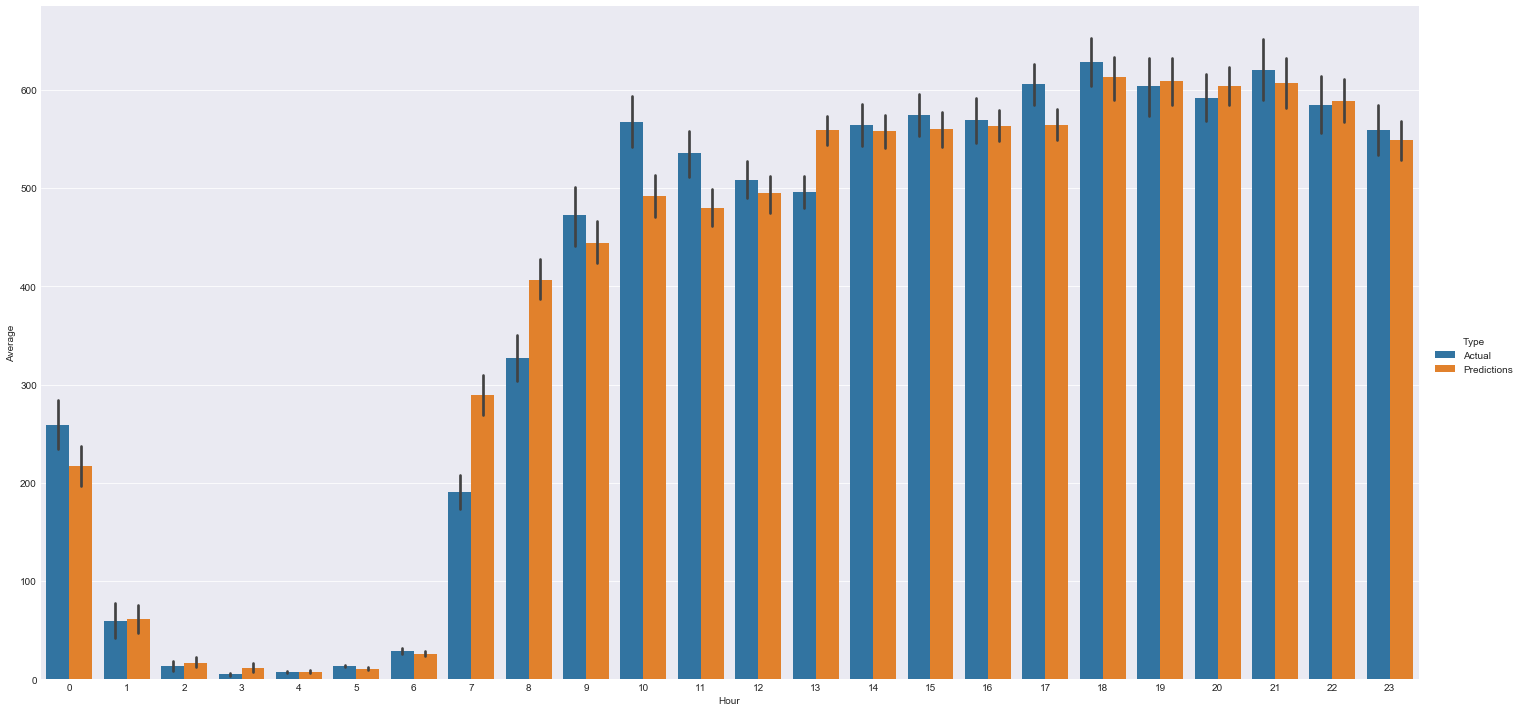

In [72]:
results_melted = pd.melt(results, id_vars="Hour", var_name="Type", value_name="Average")
sns.factorplot(x='Hour', y='Average', hue='Type', data=results_melted, kind='bar', size=10, aspect = 2)

In [50]:
ridge_pipe_mlxtend.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='aut...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [51]:
ridge_pipe_mlxtend.score(X_test,y_test)

0.79440957296631032

In [86]:
rf_mlxtend.fit(X_train, y_train)
rf_mlxtend.score(X_test,y_test)

0.85900356785057441

In [98]:
(-rf_mlxtend.feature_importances_).argsort()

array([15, 37,  6, 29,  0, 14,  1,  3, 38, 28, 32,  2, 31, 30,  7,  4, 20,
        5, 33, 35, 27, 26, 10, 25, 11, 36,  8, 16, 17,  9, 18, 21, 23, 19,
       34, 24, 22, 12, 13])

In [99]:
feature_names = data.columns

In [100]:
feature_names[(-rf_mlxtend.feature_importances_).argsort()]

Index(['Prev_2hour_Passengers', 'DayOfWeek_5', 'Avg_Delay_Arriving',
       'HourOfDay_(6.0, 12.0]', 'temp', 'Prev_hour_Passengers', 'humidity',
       'Passengers', 'DayOfWeek_6', 'HourOfDay_(-0.001, 6.0]', 'DayOfWeek_0',
       'wind_speed', 'HourOfDay_(17.5, 23.0]', 'HourOfDay_(12.0, 17.5]',
       'Cancelled_Departing_Flights', 'holiday', 'Month_5', 'precip_in',
       'DayOfWeek_1', 'DayOfWeek_3', 'Month_12', 'Month_11', 'fog', 'Month_10',
       'rain', 'DayOfWeek_4', 'clear', 'Month_1', 'Month_2', 'clouds',
       'Month_3', 'Month_6', 'Month_8', 'Month_4', 'DayOfWeek_2', 'Month_9',
       'Month_7', 'snow', 'thunderstorm'],
      dtype='object')

### Finding best tree in Random Forest Regressor to output for vis

In [106]:
best = 0
for tree in rf_mlxtend.estimators_:
    temp = tree.score(X_test, y_test)
    if temp > best:
        best = temp
        best_tree = tree

In [113]:
import os
export_graphviz(tree,
                feature_names=feature_names,
                filled=True,
                rounded=True)
os.system('dot -Tpng tree.dot -o tree.png')

/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


32512

In [87]:
gbt_mlxtend.fit(X_train, y_train)
gbt_mlxtend.score(X_test, y_test)

0.86902167897865712

In [125]:
gbt_mlxtend.estimators_

array([[ DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x1032d1f78>,
           splitter='best')],
       [ DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x1032d1f78>,
           splitter='best')],
       [ DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_le

### Using Ridge as meta-regressor

In [76]:
ridge = Ridge()
stack_ridge_pipe = make_pipeline(StackingCVRegressor(regressors = [ridge_pipe_mlxtend, rf_mlxtend, gbt_mlxtend], 
                            meta_regressor=ridge))
stack_ridge_param_grid = {
    'stackingcvregressor__meta-ridge__alpha': [0.01, 0.1, 0.5, 1.0, 10]
}

In [77]:
grid_ridge_stack = GridSearchCV(stack_ridge_pipe, stack_ridge_param_grid, cv=5, scoring='r2', refit=True, verbose=2, n_jobs=-1)
grid_ridge_stack.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] stackingcvregressor__meta-ridge__alpha=0.01 .....................
[CV] stackingcvregressor__meta-ridge__alpha=0.01 .....................
[CV] stackingcvregressor__meta-ridge__alpha=0.01 .....................
[CV] stackingcvregressor__meta-ridge__alpha=0.01 .....................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordin

[CV] ...... stackingcvregressor__meta-ridge__alpha=0.01, total= 7.0min
[CV] stackingcvregressor__meta-ridge__alpha=0.01 .....................
[CV] ...... stackingcvregressor__meta-ridge__alpha=0.01, total= 7.1min
[CV] stackingcvregressor__meta-ridge__alpha=0.1 ......................
[CV] ...... stackingcvregressor__meta-ridge__alpha=0.01, total= 7.1min
[CV] stackingcvregressor__meta-ridge__alpha=0.1 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordin

[CV] ...... stackingcvregressor__meta-ridge__alpha=0.01, total= 7.4min
[CV] stackingcvregressor__meta-ridge__alpha=0.1 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=0.1, total= 6.4min
[CV] ...... stackingcvregressor__meta-ridge__alpha=0.01, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=0.1 ......................
[CV] stackingcvregressor__meta-ridge__alpha=0.1 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=0.1, total= 6.6min
[CV] stackingcvregressor__meta-ridge__alpha=0.5 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=0.1, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=0.5 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordin

[CV] ....... stackingcvregressor__meta-ridge__alpha=0.1, total= 7.4min
[CV] stackingcvregressor__meta-ridge__alpha=0.5 ......................
[CV] ....... stackingcvregressor__meta-ridge__alpha=0.1, total= 7.4min
[CV] stackingcvregressor__meta-ridge__alpha=0.5 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordin

[CV] ....... stackingcvregressor__meta-ridge__alpha=0.5, total= 7.3min
[CV] stackingcvregressor__meta-ridge__alpha=0.5 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=0.5, total= 7.5min
[CV] stackingcvregressor__meta-ridge__alpha=1.0 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordin

[CV] ....... stackingcvregressor__meta-ridge__alpha=0.5, total= 6.4min
[CV] stackingcvregressor__meta-ridge__alpha=1.0 ......................
[CV] ....... stackingcvregressor__meta-ridge__alpha=0.5, total= 6.4min
[CV] stackingcvregressor__meta-ridge__alpha=1.0 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=0.5, total= 6.4min
[CV] stackingcvregressor__meta-ridge__alpha=1.0 ......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=1.0, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=1.0 ......................
[CV] ....... stackingcvregressor__meta-ridge__alpha=1.0, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=10 .......................
[CV] ....... stackingcvregressor__meta-ridge__alpha=1.0, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=10 .......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ....... stackingcvregressor__meta-ridge__alpha=1.0, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=10 .......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordin

[CV] ....... stackingcvregressor__meta-ridge__alpha=1.0, total= 6.5min
[CV] stackingcvregressor__meta-ridge__alpha=10 .......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........ stackingcvregressor__meta-ridge__alpha=10, total= 6.8min
[CV] stackingcvregressor__meta-ridge__alpha=10 .......................


/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV] ........ stackingcvregressor__meta-ridge__alpha=10, total= 7.0min
[CV] ........ stackingcvregressor__meta-ridge__alpha=10, total= 7.3min
[CV] ........ stackingcvregressor__meta-ridge__alpha=10, total= 6.9min
[CV] ........ stackingcvregressor__meta-ridge__alpha=10, total= 4.0min


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 44.9min finished
/Users/adamcoviensky/anaconda/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stackingcvregressor', StackingCVRegressor(cv=5,
          meta_regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
          regressors=[Pipeline(memory=None,
     steps=[('standardscaler', StandardScal...rbose=0,
             warm_start=False)],
          shuffle=True, use_features_in_secondary=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'stackingcvregressor__meta-ridge__alpha': [0.01, 0.1, 0.5, 1.0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=2)

In [79]:
grid_ridge_stack.score(X_test_np, y_test_np)

0.86863097293560698

In [81]:
grid_ridge_stack.best_params_

{'stackingcvregressor__meta-ridge__alpha': 0.1}

In [93]:
grid_ridge_stack.best_estimator_.named_steps['stackingcvregressor'].meta_regr_.coef_

array([-0.02310916,  0.35293841,  0.67934037])

In [95]:
linreg = LinearRegression()
np.mean(cross_val_score(linreg, X_train_np, y_train_np, cv=5))

0.73503303678086362

In [97]:
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

0.73354112605155919